# Hidden Markov Model analysis of mouse foraging behaviour

In this example, we fit and apply a Hidden Markov Model (HMM) to infer behavioural syllables from pre-processed mouse tracking data.

The [sample dataset](../../downloads/hmm_example_mouse_pos.pkl) is a two-hour snippet of a single mouse in a foraging assay. 
The mouse was tracked using [SLEAP](sleap:) with key body parts annotated as follows:

:::{image} ../../images/hmm-example-mouse-body-parts.png
:alt: Mouse body part annotations
:width: 50%
:align: center
:::

The data includes:
- raw centroid positions (`x`, `y`)
- Kalman-filtered estimates of centroid positions, speed, and acceleration (`smoothed_x`, `smoothed_y`, `smoothed_speed`, `smoothed_acceleration`)
- pairwise distances between key body parts (`head-spine3`, `left_ear-spine3`, `right_ear-spine3`, `spine1-spine3`)

These pairwise distances were selected based on their contribution to overall variance in body shape (i.e. length and curvature), as determined by applying Singular Value Decomposition (SVD) to a standardised distance matrix. 

## Set up environment

Create and activate a virtual environment named `hmm-example` using [uv](https://docs.astral.sh/uv/getting-started/installation/).
```bash
uv venv hmm-example --python ">=3.11" 
source hmm-example/bin/activate   
```

Install the required [`ssm` package](https://github.com/lindermanlab/ssm) and its dependencies.
```bash
uv pip install setuptools wheel numpy cython && uv pip install --no-build-isolation "git+https://github.com/lindermanlab/ssm#egg=ssm[plotting]"
```

In [ ]:
import autograd.numpy as np
import autograd.numpy.random as npr

npr.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import seaborn as sns

import ssm

In [2]:
class AeonHMM:
    """A class for training and analysing Hidden Markov Models (HMM) using the `ssm` library."""

    def __init__(self, n_state):
        """Initialise AeonHMM with the number of hidden states."""
        self.n_state = n_state  # Number of hidden states
        self.features = [
            "smoothed_speed",
            "smoothed_acceleration",
            "head-spine3",
            "left_ear-spine3",
            "right_ear-spine3",
            "spine1-spine3",
        ]  # Expected features in the input data
        self.model = None  # HMM model instance
        self.parameters = None  # Sorted model parameters (mean, variance, covariance)
        self.transition_mat = None  # Sorted transition matrix
        self.states = None  # Inferred states
        self.connectivity_mat = None  # Connectivity matrix
        self.test_lls = None  # Log-likelihoods of the test data
        self.train_lls = None  # Log-likelihoods of the training data

    def get_connectivity_matrix(self):
        """Compute the normalised connectivity matrix from the inferred states."""
        connectivity_mat = np.zeros((self.n_state, self.n_state))
        states = self.states
        # Count transitions between states
        for i in range(len(states) - 1):
            if states[i + 1] != states[i]:
                connectivity_mat[states[i]][states[i + 1]] += 1
        # Normalise to sum to 1
        for i in range(self.n_state):
            total = np.sum(connectivity_mat[i])
            if total > 0:
                connectivity_mat[i] /= total

        return connectivity_mat

    def fit_model(self, train_data, num_iters=50):
        """Fit the HMM model to the training data using the EM algorithm."""
        fitting_input = np.array(train_data)
        self.model = ssm.HMM(
            self.n_state, len(fitting_input[0]), observations="gaussian"
        )
        lls = self.model.fit(
            fitting_input, method="em", num_iters=num_iters, init_method="kmeans"
        )
        self.train_lls = lls

    def infer_states(self, test_data):
        """Infer states for the test data."""
        obs = np.array(test_data)
        self.test_lls = self.model.log_likelihood(obs)
        self.states = self.model.most_likely_states(obs)

    def sort(self, sort_idx):
        """Sort the model parameters, transition matrix, and inferred states based on the provided indices."""
        # Sort Gaussian means: shape (n_features, n_state)
        parameters_mean_sorted = self.model.observations.params[0][sort_idx].T
        # Extract and sort variances: shape (n_features, n_state)
        parameters_var = np.zeros((self.n_state, len(self.features)))
        for i in range(self.n_state):
            for j in range(len(self.features)):
                # state i, feature j
                parameters_var[i, j] = self.model.observations.params[1][i][j][j]
        parameters_var_sorted = parameters_var[sort_idx].T
        # Sort covariance matrices: shape (n_state, n_features, n_features)
        parameters_covar_sorted = self.model.observations.params[1][sort_idx]
        self.parameters = [
            parameters_mean_sorted,
            parameters_var_sorted,
            parameters_covar_sorted,
        ]
        # Sort transition matrix: shape (n_state, n_state)
        self.transition_mat = (
            self.model.transitions.transition_matrix[sort_idx].T[sort_idx].T
        )
        # Compute connectivity matrix
        self.connectivity_mat = self.get_connectivity_matrix()
        # Reassign state labels to reflect new order
        new_values = np.empty_like(self.states)
        for i, val in enumerate(sort_idx):
            new_values[self.states == val] = i
        self.states = new_values

## Load sample data
The sample dataset can be downloaded [here](../../downloads/hmm_example_mouse_pos.pkl). 
Please change the value of `file_path` to the location where you saved the file.

In [130]:
file_path = "/path/to/hmm_example_mouse_pos.pkl"

In [4]:
with open(file_path, "rb") as file:
    mouse_pos = pickle.load(file)

# Select only the required features for the HMM
mouse_pos = mouse_pos[
    [
        "smoothed_speed",
        "smoothed_acceleration",
        "head-spine3",
        "spine1-spine3",
        "left_ear-spine3",
        "right_ear-spine3",
    ]
]
mouse_pos.head()

,smoothed_speed,smoothed_acceleration,head-spine3,spine1-spine3,left_ear-spine3,right_ear-spine3
2024-02-01 07:00:00.080,6.765046,19.325969,17.767353,12.744590,17.301722,15.257318
2024-02-01 07:00:00.180,8.032855,13.389354,17.269546,12.521794,18.267784,15.036750
2024-02-01 07:00:00.280,8.410684,7.612856,18.342884,12.943109,18.868068,15.568200
2024-02-01 07:00:00.380,7.863123,9.032341,18.010769,12.811849,18.209636,14.367178
2024-02-01 07:00:00.480,6.422148,15.558013,18.457386,12.783098,18.527658,15.594391


## Training and inference

In this two-hour example, we use the data in the first hour to train the model, 
and use the model to infer the hidden states of mouse in the second hour.

In [5]:
start = mouse_pos.index[0]
train_mouse_pos = mouse_pos[start : start + pd.Timedelta("1h")]
test_mouse_pos = mouse_pos[start + pd.Timedelta("1h") : start + pd.Timedelta("2h")]

We initialise the model with 10 hidden states and train it using the Expectation-Maximisation (EM) algorithm over 50 iterations on the 6 selected features:
- smoothed centroid speed,
- smoothed acceleration
- distance between `head` and `spine3`
- distance between `spine1` and `spine3`
- distance between `left_ear` and `spine3`
- distance between `right_ear` and `spine3`

We then use the trained model to infer the hidden states of the mouse in the test data (the second hour).

In [6]:
mouse_hmm = AeonHMM(n_state=10)
mouse_hmm.fit_model(train_mouse_pos)  # Set `num_iters` as needed
mouse_hmm.infer_states(test_mouse_pos)

  0%|          | 0/50 [00:00<?, ?it/s]

## Parameter sorting

To make it easier to interpret the model, we can sort the inferred states by the mean centroid speed (`smoothed_speed`) in ascending order.
The model parameters, transition matrix, and inferred states can then be reordered using `AeonHmm.sort()`, such that state 0 corresponds to the slowest, state 1 to the next slowest, and so on.

In [ ]:
state_mean_speed = mouse_hmm.model.observations.params[0].T[0]
sort_idx = np.argsort(state_mean_speed, -1)
mouse_hmm.sort(sort_idx)

## Visualise inferred states

Below we colour-code the inferred states and plot these over time.

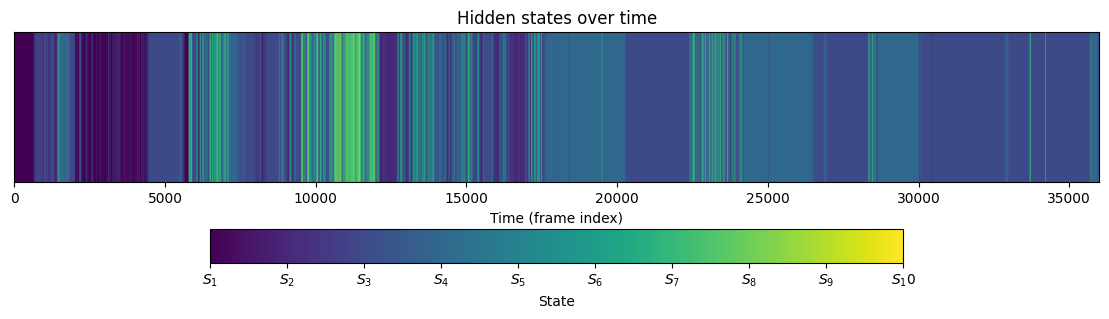

In [91]:
fig, ax = plt.subplots(figsize=(14, 3))
# Plot the state color bars
states_colored = mouse_hmm.states.reshape(1, -1)
im = ax.imshow(
    states_colored,
    aspect="auto",
    vmin=0,
    vmax=mouse_hmm.n_state - 1,
    extent=[0, len(mouse_hmm.states), 0, 0.2],
)
ax.set_xlim(0, len(mouse_hmm.states))
ax.set_yticks([])
ax.set_xlabel("Time (frame index)")
ax.set_title("Hidden states over time")
# Add colorbar with state labels
cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.2, shrink=0.8)
cbar.set_label("State")
cbar.set_ticks(range(mouse_hmm.n_state))
cbar.set_ticklabels([f"$S_{i + 1}$" for i in range(mouse_hmm.n_state)])
plt.show()

We can also visualise how key behavioural features differ across the 10 hidden states by plotting the mean and 95% confidence interval for each state, as estimated from the training data.

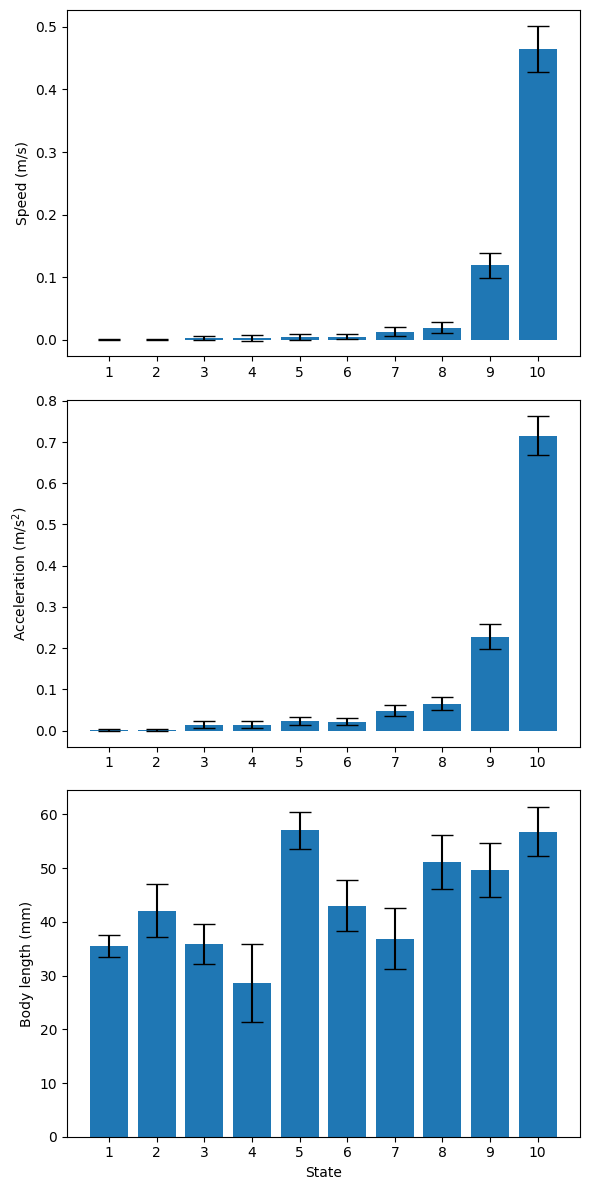

In [114]:
# Define feature labels
features = ["Speed (m/s)", "Acceleration (m/s$^2$)", "Body length (mm)"]
scale = 2e-3  # Scale for speed and acceleration
n_features = len(features)
n_state = mouse_hmm.n_state
params = mouse_hmm.parameters
fig, axs = plt.subplots(n_features, 1, figsize=(6, 12))
for i in range(n_features):
    if i > 1:
        scale = 2  # Body length is in mm, no scaling needed
    axs[i].bar(
        range(n_state),
        params[0][i] * scale,
        yerr=1.65 * (params[1][i] ** 0.5) * scale,  # 95% CI = ±1.65*std
        capsize=8,  # Size of error bar caps
    )
    axs[i].set_xticks(range(0, n_state), [str(j + 1) for j in range(n_state)])
    axs[i].set_ylabel(features[i])
axs[2].set_xlabel("State")
plt.tight_layout()
plt.show()

The transition matrix can be visualised as a heatmap, where the diagonal entries indicate the probability of remaining in the same state, while off-diagonal entries represent transitions between different states.

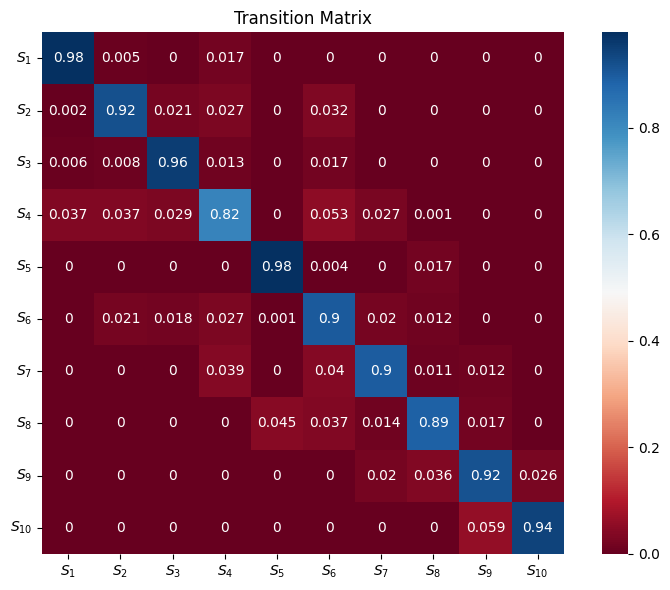

In [129]:
matrix = mouse_hmm.transition_mat
annot_array = np.array([[round(item, 3) for item in row] for row in matrix])
labels = ["$S_{" + str(i + 1) + "}$" for i in range(len(matrix))]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    matrix,
    cmap="RdBu",
    ax=ax,
    square="True",
    cbar=True,
    annot=annot_array,
)
ax.set_title("Transition Matrix")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels, rotation=0)
plt.tight_layout()
plt.show()